<a href="https://colab.research.google.com/github/tikovka72/yandex-lyceum-selection-round/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение

## Подготовка
Установить все нужные библиотеки для работы программ (После этого нужно будет перезагрузить ядро)

### Установка зависимостей

In [ ]:
!pip3 install -U matplotlib==3.5.1 \
                 tensorflow==2.7.0 \
                 pandas==1.3.5 \
                 numpy==1.19.5

### Определение переменных для дальнейшей работы

In [133]:
# columns
survived = 'survived'
pclass = 'pclass'
sex = 'sex'
age = 'age'
sibsp = 'sibsp'
parch = 'parch'
fare = 'fare'
embarked = 'embarked'
class_ = 'class'
who = 'who'
adult_male = 'adult_male'
deck = 'deck'
embark_town = 'embark_town'
alive = 'alive'
alone = 'alone'

# values
unknown = 'Unknown'
u = 'U'

# для диаграмм

# размеры фигур для .set_size(inches) 
one_axes_size = 10, 5
two_axes_size = 20, 5
three_axes_size = 30, 5

# 2 полотна по горизонтали на фигуре 
two_axes_in_row = 1, 2
three_axes_in_row = 1, 3

# цвета 
good_color = '#A6B401'
second_good_color = '#C3F294'
thrid_good_color = '#EFF67B'
bad_color = '#D50102'
neutral_color = '#B3E7DC'
second_neutral_color = '#B2B1AA'

# другие значения
bar_width = 0.4
slim_bar_width = 0.2

marker_size_l = 6

## 1. Скачать файл по ссылке

In [2]:
!wget 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv' 'titanic.csv'

--2022-02-14 13:38:54--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57018 (56K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  55.68K  --.-KB/s    in 0.01s   

2022-02-14 13:38:54 (4.68 MB/s) - ‘titanic.csv’ saved [57018/57018]

--2022-02-14 13:38:54--  http://titanic.csv/
Resolving titanic.csv (titanic.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘titanic.csv’
FINISHED --2022-02-14 13:38:54--
Total wall clock time: 0.2s
Downloaded: 1 files, 56K in 0.01s (4.68 MB/s)


## 2. Изучение данных

### Информация

In [3]:
import pandas as pd

df = pd.read_csv('titanic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


### Пропуски
* возраст (`age`, 177 пропусков)
* порт посадки (`embarked`, 2 пропуска)
* палуба (`deck`, 688 пропусков)
* город посадки (`embark_town`, 2 пропуска)

### Заполнение пропусков
#### Возраст 
Принято решение написать небольшую модель,
обучить ее на заполненных данных
и предположить примерный возраст в пропущенных ячейках.

#### Порт посадки 
Все пропуски = `U` (unknown).
Данный столбец в дальнейшем не потребуется, два пропущенных значения я решил заменить на `U` вместо удаления двух строк, так как объем данных и так достаточно мал.

#### Город посадки
Все пропуски = `Unknown`.
То же самое, что и с портом.

#### Палуба
Все пропуски = `U`.
В данном столбце очень мало значений, нормально обучить сеть на таком количестве затруднительно, а моего опыта в обработке данных не хватает, чтобы вручную найти закономерности и связи с другими столбцами. Данный столбец не потребуется для дальнейшей работы.

#### Пропуски посадки

In [4]:
def fill_na_embark(data_frame: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для заполнения пропусков embarked и embark_town
    
    """
    data_frame[embarked] = data_frame[embarked].fillna(u)
    data_frame[embark_town] = data_frame[embark_town].fillna(unknown)

    return data_frame

In [5]:
def for_print_embark(data_frame: pd.DataFrame, column_offset: int = 4) -> pd.DataFrame:
    """
    Функция для отображения информации 
    об уникальных значениях в столбцах 'embarked' и 'embark_town'

    """
    for_print = [('Порты:', 'Города:')]
    max_len_port = len(for_print[0][0])
    output_str = ''

    unique_ports, unique_towns = data_frame[embarked].unique(), data_frame[embark_town].unique()
    
    for index in range(max(len(unique_ports), len(unique_towns))):
        # Доводим оба столбца до одной длины
        temp_port = unique_ports[index] if index < len(unique_ports) else ''
        temp_town = unique_towns[index] if index < len(unique_towns) else ''

        max_len_port = max(max_len_port, len(temp_port))

        for_print.append((temp_port, temp_town))

    for port, town in for_print: 
        # смотрим, сколько занимает длина строки порта 
        # и делаем на основе этой строки отступ для второй колонки
        output_str += f'{port}{" " * (max_len_port + column_offset - len(port))}{town}\n'

    return output_str

In [6]:
df = fill_na_embark(df)
print(for_print_embark(df))

Порты:    Города:
S         Southampton
C         Cherbourg
Q         Queenstown
U         Unknown



#### Пропуски возраста

##### Подготовка данных

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import mse
from tensorflow.keras.metrics import mae
from tensorflow.keras.activations import relu, sigmoid

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from typing import Iterable

In [8]:
# константы для нормализации
X_COLUMNS = [pclass, sex, sibsp, parch, fare, class_, alive, alone]
Y_COLUMNS = [age]
AGE_NORMALIZER = 0.01
FARE_NORMALIZER = 0.001
SIBSP_NORMALIZER = 0.1
PARCH_NORMALIZER = 0.1
CLASSES = {'First': 0.1, 'Second': 0.5, 'Third': 0.9}
P_CLASSES = {1: 0.1, 2: 0.5, 3: 0.9}


def prepare_data(data_frame): 
    """
    Функция для подготовки данных 

    """
    data_frame_copy = data_frame.copy()
    data_frame_copy[pclass] = data_frame_copy[pclass].apply(lambda text_pclass: P_CLASSES[text_pclass])
    data_frame_copy[sex] = data_frame_copy[sex].apply(lambda text_sex: int(text_sex == 'female'))
    data_frame_copy[fare] *= FARE_NORMALIZER
    data_frame_copy[sibsp] *= SIBSP_NORMALIZER
    data_frame_copy[parch] *= PARCH_NORMALIZER
    data_frame_copy[class_] = data_frame_copy[class_].apply(lambda text_class: CLASSES[text_class])
    data_frame_copy[alive] = data_frame_copy[alive].apply(lambda text_alive: int(text_alive == 'yes'))
    data_frame_copy[alone] = data_frame_copy[alone].apply(int)

    data_frame_copy[age] *= AGE_NORMALIZER

    return data_frame_copy

In [19]:
data = df[df.loc[:, age].notna()]
prepared_data = prepare_data(data)
x_data, y_data = prepared_data[X_COLUMNS].to_numpy(), prepared_data[Y_COLUMNS].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9)

##### Аугментация данных

In [ ]:
RANDOM_NUMBER_VARIANT = 1
RANDOM_CHOICE_VARIANT = 2


def data_augmentation(x: np.array, y: np.array, count: int = 1, x_transformations: Iterable = tuple()):
    """
    Функция для аугментации данных. !Возвращает только новые данные
    x: входные данные
    y: выходные данные
    count: количество новых данных
    x_transformations: список с инструкциями для преобразований,
        где инструкции могут быть двух видов:
        1. {
            't_variant': 1       вид инструкции, 1 - выбор случайного числа из диапазона
            'index': int         индекс столбца, нод которым надо произвести данную инструкцию
            'min': float         минимальное возможное значение столбца
            'max': float         максимальное возможное значение для столбца
            'max_plus': float    какое максимальное отклонение в большую сторону
                                 может быть для значения x,
                                 то есть задает диапазон [x, x + max_plus] для нового значения
            'max_minus': float   аналогично 'max_plus', но задает [x - max_minus, x]
                                 * 'max_minus' и 'max_plus' задают границы для определенного значения x,
                                 * а 'max' и 'min' задают глобальные границы, за которые невозможно выйти ни одному x
            'round': int         до какого знака после запятой нужно округлить
        }
        2. {
            't_variant': 2      вид инструкции, 2 - выбор из набора вариантов
            'index': int
            'choice': list      массив из вариантов новых значений. если x нет в массиве, он не меняется
            'max_plus': int     на сколько индексов можно уйти в правую сторону от значения x,
                                необходимо для отсортированных массивов, к примеру когда есть несколько классов
                                и изменять данные нужно только переходом в соседние классы
            'max_minus': int    аналогично 'max_plus', только в левую сторону
                                * для того, чтобы выбор был из всего массива,
                                * 'max_plus' и 'max_minus' следует установить такими,
                                * чтобы они были больше длины массива 'choice'
        }
    """
    new_x, new_y = [0] * count, [0] * count
    for new_index in range(count):
        # выбираем случайный элемент из массива
        old_index = np.random.choice(len(x), 1)
        new_x_elem = np.array(x[old_index], copy=True)[0]

        # применяем изменения
        for transform in x_transformations:
            if transform['t_variant'] == RANDOM_NUMBER_VARIANT:
                minimum = max(transform['min'], new_x_elem[transform['index']] - transform['max_minus'])
                maximum = min(transform['max'], new_x_elem[transform['index']] + transform['max_plus'])
                new_value = np.random.uniform(minimum, maximum)
                new_x_elem[transform['index']] = round(new_value, transform['round'])

            elif transform['t_variant'] == RANDOM_CHOICE_VARIANT:
                # если нет элемента в массиве с новыми выборами, пропускаем
                if new_x_elem[transform['index']] not in transform['choice']:
                    continue

                index_before_transformation = transform['choice'].index(new_x_elem[transform['index']])
                minimum_index = max(0, index_before_transformation - transform['max_minus'])
                maximum_index = min(len(transform['choice']),
                                    index_before_transformation + transform['max_plus'] + 1)

                choice_from = transform['choice'][minimum_index:maximum_index]
                new_value = np.random.choice(choice_from)
                new_x_elem[transform['index']] = new_value
                
        new_x[new_index] = new_x_elem
        new_y[new_index] = y[old_index]
    return np.array(new_x), np.array(new_y)[:, 0]  # в y создается лишняя размерность, убираем ее


In [ ]:
new_x_train, new_y_train = data_augmentation(
    x_train, y_train, count=300,
    x_transformations=[
        {  # sibsp (количество родственников) может меняться 
           # в большую или меньшую сторону на 1 
            'index': 2,
            't_variant': RANDOM_CHOICE_VARIANT,
            'choice': [0.1 * i for i in range(8)],
            'max_plus': 1,
            'max_minus': 1,
        },
        {  # parch (количество детей/родителей) может меняться 
           # в меньшую сторону на 1 
            'index': 3,
            't_variant': RANDOM_CHOICE_VARIANT,
            'choice': [0.1 * i for i in range(8)],
            'max_plus': 0,
            'max_minus': 1,
        },
        {  # fare (оплата билета) может варьироваться на $10 вниз или вверх 
           # 0.010, а не 10 потому что данные уже нормализованы 
           # до значений в пределах [0, 1]
            'index': 4,
            't_variant': RANDOM_NUMBER_VARIANT,
            'min': 0,
            'max': 1,
            'max_plus': 0.010,
            'max_minus': 0.010,
            'round': 7
        }
    ])


In [ ]:
# собираем сгенерированные данные с уже имеющимися 
total_x_train, total_y_train = (
    np.concatenate((x_train, new_x_train)), 
    np.concatenate((y_train, new_y_train))
)

In [ ]:
print(f'Всего данных для обучения{total_x_train.shape}')

Всего данных для обучения(942, 8)


##### Создание и обучение модели

In [ ]:
def create_model():
    """
    Функция для создания модели
    
    """
    input_layer = Input(len(X_COLUMNS))
    layers_values = ((16, relu), 
                     (256, relu), 
                     (512, relu),
                     (768, relu),
                     (768, relu),
                     (768, relu),
                     (1024, relu),
                     (4096, relu),
                     (4096, relu),
                     (1024, relu),
                     (512, relu),
                     (256, relu),
                     (128, relu),
                     (128, relu), 
                     (56, relu), 
                     (len(Y_COLUMNS), sigmoid))
    last_layer = Dense(layers_values[0][0], layers_values[0][1])(input_layer)
    for units, activation in layers_values[1:]:
        last_layer = Dense(units, activation)(last_layer)

    return Model(input_layer, last_layer)

In [ ]:
model = create_model()
model.compile(optimizer=Adam(), loss=mse, metrics=[mae])

In [ ]:
BATCH_SIZE = 4
EPOCHS = 600
history = model.fit(total_x_train, total_y_train, batch_size=BATCH_SIZE, epochs=EPOCHS).history
# убрал длинный вывод данных, оставил только 5 первых и последних эпох

Epoch 1/600
236/236 [==============================] - 7s 22ms/step - loss: 0.0225 - mean_absolute_error: 0.1193
Epoch 2/600
236/236 [==============================] - 5s 22ms/step - loss: 0.0193 - mean_absolute_error: 0.1116
Epoch 3/600
236/236 [==============================] - 6s 24ms/step - loss: 0.0184 - mean_absolute_error: 0.1087
Epoch 4/600
236/236 [==============================] - 6s 26ms/step - loss: 0.0189 - mean_absolute_error: 0.1098
Epoch 5/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0175 - mean_absolute_error: 0.1061
...
Epoch 595/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0105 - mean_absolute_error: 0.0781
Epoch 596/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0106 - mean_absolute_error: 0.0784
Epoch 597/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0107 - mean_absolute_error: 0.0788
Epoch 598/600
236/236 [==============================] - 4s 18ms/step - loss: 0.0104 -

##### Итоги обучения

Text(0, 0.5, 'Точность, %')

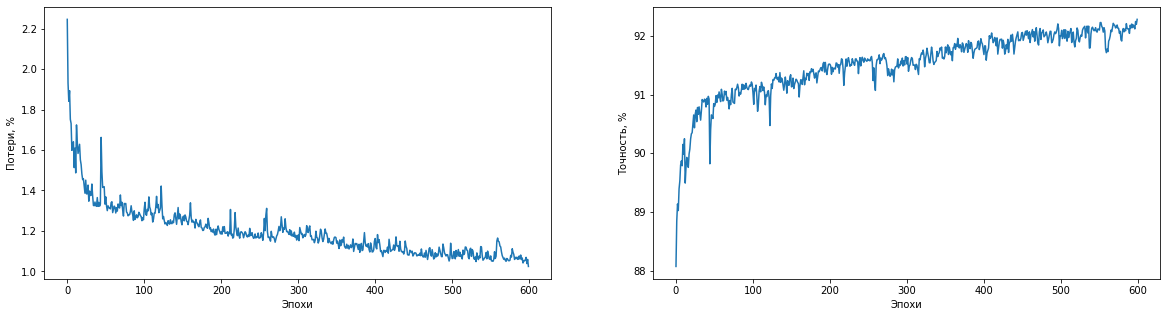

In [ ]:
fig, (losses_axes, metrics_axes) = plt.subplots(*two_axes_in_row)
fig.set_size_inches(two_axes_size)
fig.suptitle('Итоги обучения')

losses_axes.plot([x * 100 for x in history.get('loss')], color=good_color)

losses_axes.set_title('Потери по эпохам')
losses_axes.set_xlabel('Эпохи')
losses_axes.set_ylabel('Потери, %')
losses_axes.grid(True)

metrics_axes.plot([(1 - x) * 100 for x in history.get('mean_absolute_error')], 
                  color=good_color)

metrics_axes.set_title('Точность по эпохам')
metrics_axes.set_xlabel('Эпохи')
metrics_axes.set_ylabel('Точность, %')
metrics_axes.grid(True)

plt.show()

In [ ]:
print('Средняя ошибка на тестовых данных (в годах): '
      f'{round(model.evaluate(x_test, y_test, verbose=0)[1] / AGE_NORMALIZER, 1)}')

Средняя ошибка на тестовых данных (в годах): 7.7


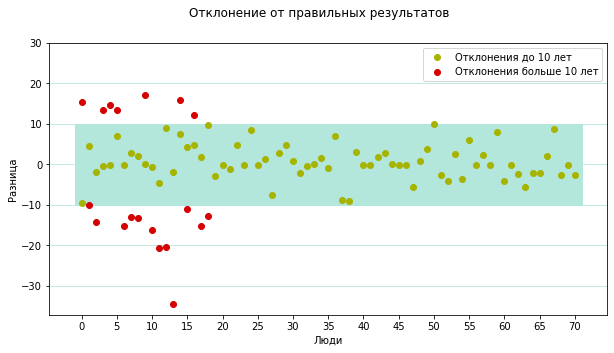

In [154]:
fig, axes = plt.subplots()
fig.set_size_inches(*one_axes_size)
fig.suptitle('Отклонение от правильных результатов')

predicts = model.predict(x_test)

values = predicts / AGE_NORMALIZER - y_test / AGE_NORMALIZER
good_values = values[np.absolute(values) <= 10]
bad_values = values[np.absolute(values) > 10]

axes.fill_between(
    np.arange(-1, max(len(good_values), len(bad_values)) + 1),
     -10, 10, color=neutral_color)

axes.plot(good_values, 
          linewidth=0, 
          markersize=marker_size_l, 
          marker='o',
          color=good_color, 
          label='Отклонения до 10 лет')
axes.plot(bad_values,
          linewidth=0,
          markersize=marker_size_l,
          marker='o',
          color=bad_color,
          label='Отклонения больше 10 лет')


axes.set_xlabel('Люди')
axes.set_ylabel('Разница')
axes.set_yticks(range(-30, 31, 10))
axes.set_xticks(range(0, max(len(good_values), len(bad_values)), 5))
axes.grid(True, axis='y', color=neutral_color)
axes.legend()

plt.show()

##### Сохранение модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round/models

In [ ]:
model.save('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model/assets


In [ ]:
model.save('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model.h5')

##### Загрузка модели

In [9]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
model = load_model('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model')

##### Вставка возрастов

In [11]:
def age_reformer(row):
    """
    Вставляет все пропуски в столбце возраст

    """
    if row.isnull()[age]:
        prepared_row = prepare_data(row.to_frame().transpose())
        age_value = model.predict(np.asarray(
            prepared_row[X_COLUMNS].to_numpy()).astype('float32'))[0][0]
        row[age] = round(age_value / AGE_NORMALIZER)
    return row

In [12]:
df = df.apply(age_reformer, 1)

##### Решение конфликта `adult_male` и `age`
В датасете присутствует столбец `adult_male`, который был рассчитан автором такой функцией:
```
df["who"] = df[["age", "sex"]].apply(woman_child_or_man, axis=1)
df["adult_male"] = df.who == "man"


def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]
```
Но так как `np.nan < 16 == False`, то все мужчины, у которых не обозначен возраст, считаются взрослыми. После восстановления возраста можно исправить столбец `adult_male`, помимо этого я хочу в столбце `who` разбить класс `child` на `boy` и `girl`

In [155]:
def who_replace(row): 
    # Берем сначала по индексу возраст, потом пол 
    row[who] = (('man', 'woman'), ('boy', 'girl'))[row[age] < 16][row[sex] == 'female']
    return row

In [15]:
df = df.apply(who_replace, 1)
df[adult_male] = df[who] == 'man'

#### Пропуски палубы


In [16]:
def fill_na_deck(data_frame: pd.DataFrame) -> pd.DataFrame:
    data_frame[deck] = data_frame[deck].fillna(u)

    return data_frame

In [17]:
df = fill_na_deck(df)

#### Сохранение заполненной таблицы

In [18]:
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round/csv

In [19]:
df.to_csv('/content/drive/MyDrive/yandex-lyceum-selection-round/csv/filled_titanic.csv')

#### Загрузка заполненной таблицы

In [21]:
df = pd.read_csv('/content/drive/MyDrive/yandex-lyceum-selection-round/csv/filled_titanic.csv')

## Ответы на вопросы

### a. Кого больше среди пассажиров — мужчин или женщин?

In [23]:
df[who].value_counts()

man      529
woman    262
girl      52
boy       48
Name: who, dtype: int64

| Возраст  | Мужчин | Женщин | 
|----------|:------:|:------:|
| Взрослые |  529   |   262  |
|   Дети   |   48   |    52  | 
|  Всего   |  577   |   314  | 

В целом **мужчин было больше** среди пассажиров , но если смотреть на детей, то в этом случае девочки преобладают, но ответ на вопрос - **больше было мужчин**.



### b. Каков процент взрослых мужчин от всех пассажиров?
Взрослых мужчин от всех пассажиров: `59%`.

In [70]:
print(f'{round(df[df[adult_male]].shape[0] / df.shape[0] * 100)}% взрослых мужчин')

59% взрослых мужчин


### c. Сколько людей в каждом классе?

In [71]:
df[class_].value_counts()

Third     491
First     216
Second    184
Name: class, dtype: int64

| Класс  | Количество |
|--------|:----------:|
| Первый |     216    |
| Второй |     184    | 
| Третий |     491    | 


## 4. Выводы из результатов

Из метода `describe` мы можем узнать, что среднеквадратичное отклонение в столбцах `age` и `fare` достаточно большое, что может говорить о большом разбросе данных в данных столбцах. Интересен столбец `sibsp` - количество родственников на борту, только на `75%` появляется значение, равное одному родственнику. Большинство пассажиров путешествовали в одиночестве. Также эти же столбцы интересны и в цене билета (`fare`): `50%` пассажиров заплатили за билет не больше  `$14` при том, что максимальная цена билета была,  `$512`. Из этого можно сделать вывод, что на борту было относительно мало богатых людей. (В этом и последующих пунктах за единицу измерения цены билета я буду использовать `$`, так как нигде точно не указано, в какой валюте этот столбец).

In [26]:
df.describe()

,Unnamed: 0,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,29.067531,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.779669,1.102743,0.806057,49.693429
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Средний возраст выживших 
Средний возраст выживших: 28 лет.

In [27]:
print(f'Средний возраст выживших: {round(df[df[survived] == 1][age].mean())} лет')

Средний возраст выживших: 28 лет


#### Процент выживших по классам
Процент выживших прямо зависит от класса, из чего можно сделать вывод, что безопасность пассажиров также зависит от него. В первом классе спаслось более половины пассажиров при том, что этот класс занимал `24%` всех пассажиров. 

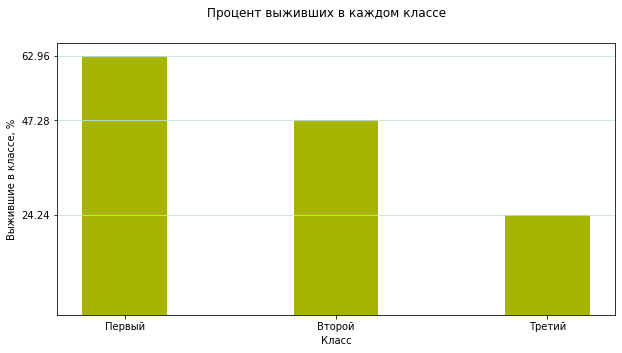

In [81]:
fig, axes = plt.subplots()
fig.set_size_inches(*one_axes_size)
fig.suptitle('Процент выживших в каждом классе')
# вычисляет сколько процентов выживших в каждом классе 
# делит, потом сортирует по возрастанию класса 
items = np.array(sorted((
    df[df[survived] == 1][pclass].value_counts() / 
    df[pclass].value_counts() * 100).items(), key=lambda column: column[0]))

axes.bar(items[:, 0], items[:, 1], width=0.4, color=good_color)

axes.set_xticks(items[:, 0])
axes.set_xticklabels(('Первый', 'Второй', 'Третий'))
axes.set_yticks(items[:, 1])
axes.set_ylabel('Выжившие в классе, %')
axes.set_xlabel('Класс')
axes.grid(True, axis='y', color=neutral_color)

plt.show()

#### Выжившие по цене билета
Как и ожидалось, количество выживших прямо зависит от цены билета: чем больше цена, тем больше относительное количество выживших. Переход в "положительное" количество выживших виден при цене билета, равном примерно `$ln(3.95) ~ $51`

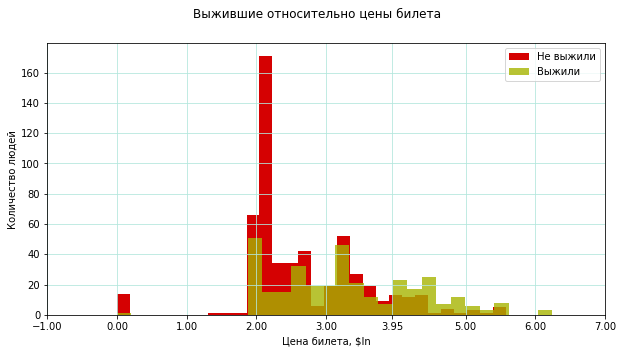

In [141]:
fig, ax = plt.subplots()
fig.set_size_inches(*one_axes_size)
fig.suptitle('Выжившие относительно цены билета')

bins = 30

not_survived_fare = df[df[survived] == 0][fare].apply(np.log).replace(float('-inf'), 0)
not_survived_fare.hist(
    bins=bins, 
    ax=ax, 
    label='Не выжили', 
    color=bad_color)

survived_fare = df[df[survived] == 1][fare].apply(np.log).replace(float('-inf'), 0)
survived_fare.hist(
    bins=bins, 
    ax=ax, 
    label='Выжили', 
    alpha=0.8,
    color=good_color)

ax.set_xlabel('Цена билета, $ln')
ax.set_ylabel('Количество людей')
ax.set_xticks(list(ax.get_xticks()[ax.get_xticks() != 4]) + [3.95])
ax.legend()
ax.grid(True, color=neutral_color)

plt.show()

### Проверка на нормальность

#### Возраст
В данных возраста всех пассажиров присутствует небольшая положительная асимметрия

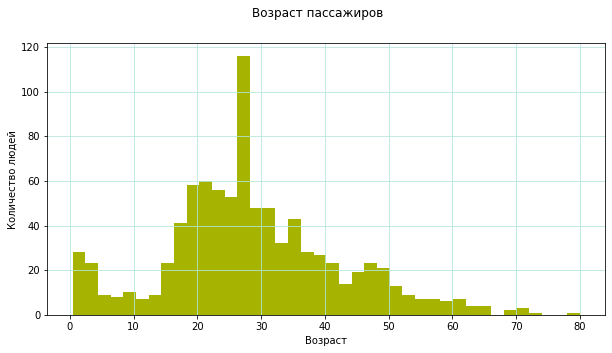

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(*one_axes_size)
fig.suptitle('Возраст пассажиров')

df[age].hist(bins=40, ax=ax, color=good_color)

ax.set_xlabel('Возраст')
ax.set_ylabel('Количество людей')
ax.grid(True, color=neutral_color)

plt.show()

Если смотреть на возрасты по классам, то данные распределены нормально только в первом и втором классах, в третьем классе присутствует положительная асимметрия, которая скорее всего и переходит в асимметрию во всей выборке

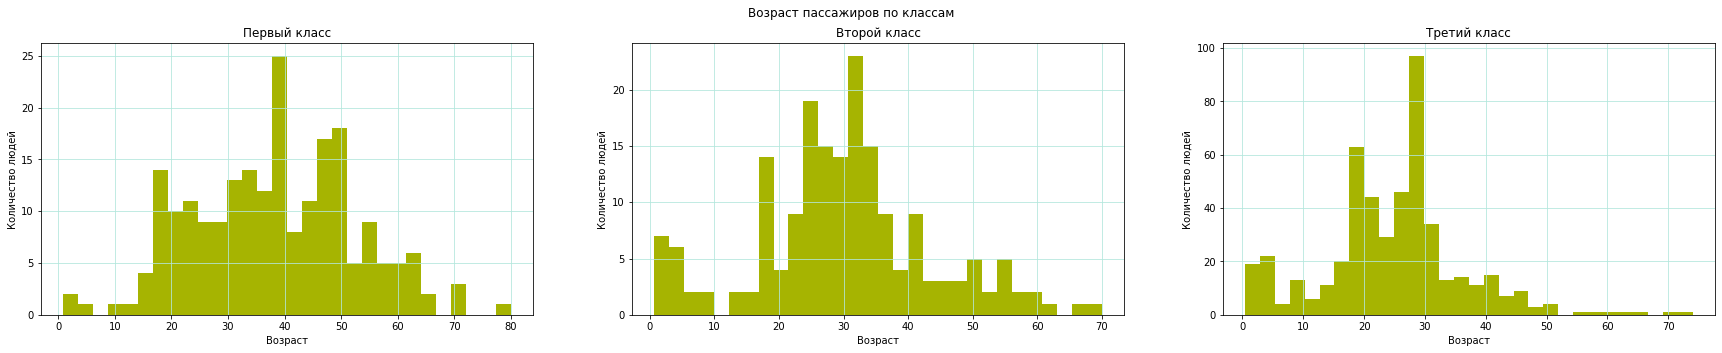

In [106]:
fig, axeses = plt.subplots(*three_axes_in_row)
fig.suptitle('Возраст пассажиров по классам')

fig.set_size_inches(*three_axes_size)


classes = ('Первый класс', 'Второй класс', 'Третий класс')
for index, ax in enumerate(axeses): 
    ax.set_title(classes[index])
    df[df[pclass] == index + 1][age].hist(bins=30, ax=ax, color=good_color)
    ax.set_xlabel('Возраст')
    ax.set_ylabel('Количество людей')
    ax.grid(True, color=neutral_color)

plt.show()

#### Цена билета
В этом столбце присутствует очень большая положительная асимметрия. 
Я попробовал взять логарифм от значений (прочитал, что в целом так правильно рассматривать денежные значения), чтобы получить логнормальное распределение, это немного исправило ситуацию, но глобально ничего почти не изменилось. Подавляющее большинство взяло дешевые билеты.

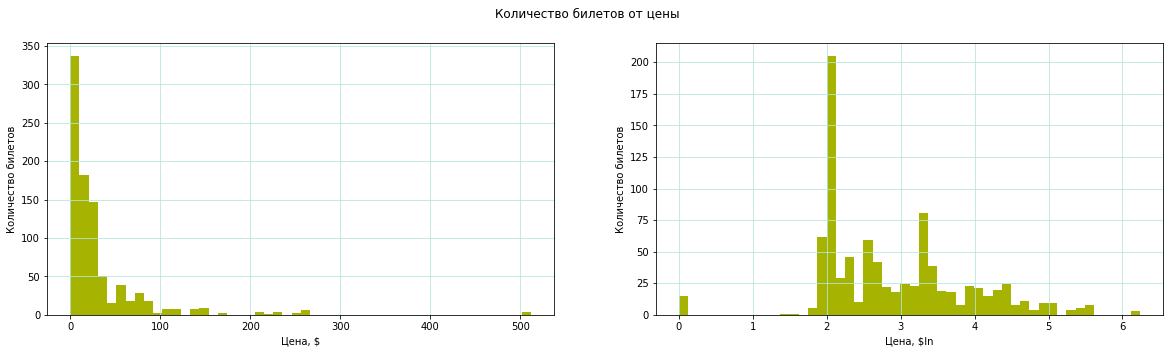

In [115]:
fig, (axes, axes_ln) = plt.subplots(*two_axes_in_row)
fig.set_size_inches(*two_axes_size)
fig.suptitle('Количество билетов от цены')

bins = 50

df[fare].hist(bins=bins, ax=axes, color=good_color)
axes.set_xlabel('Цена, $')
axes.set_ylabel('Количество билетов')
axes.grid(True, color=neutral_color)

# Заменяем все значения 
# логарифм от 0 равен -inf, 
# поэтому для построения данной гистограммы пришлось заменять -inf на 0
df[fare].apply(np.log).replace(float('-inf'), 0).hist(
    bins=bins, 
    ax=axes_ln,
    color=good_color)
axes_ln.set_xlabel('Цена, $ln')
axes_ln.set_ylabel('Количество билетов')
axes_ln.grid(True, color=neutral_color)

plt.show()

### Корреляция между возрастом и ценой билета
Как видно из графиков ниже, корреляции между этими двумя столбцами нет(

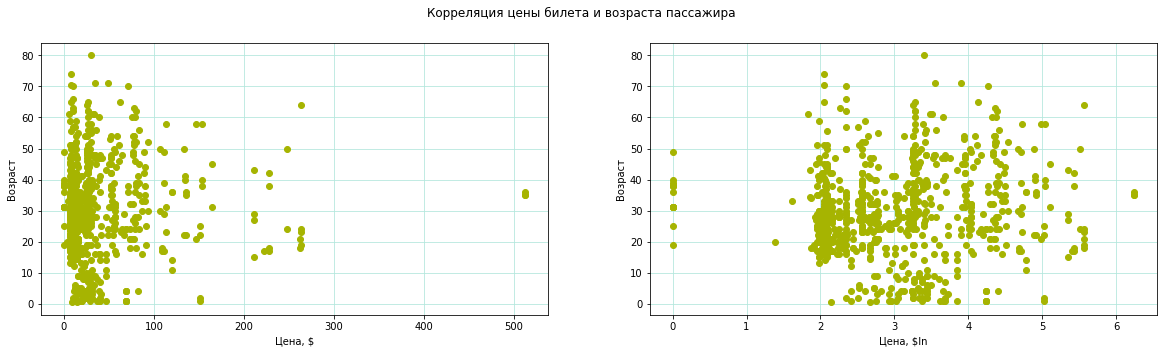

In [119]:
fig, (axes, axes_ln) = plt.subplots(*two_axes_in_row)
fig.set_size_inches(*two_axes_size)
fig.suptitle('Корреляция цены билета и возраста пассажира')
# Корреляция между возрастом и ценой билета
axes.plot(df[fare], df[age], linewidth=0, marker='o', color=good_color)
axes.set_xlabel('Цена, $')
axes.set_ylabel('Возраст')
axes.grid(True, color=neutral_color)

# корреляция между возрастом и логарифмом цены билеты
axes_ln.plot(df[fare].apply(np.log).replace(float('-inf'), 0), df[age], 
             linewidth=0, 
             marker='o', 
             color=good_color)

axes_ln.set_xlabel('Цена, $ln')
axes_ln.set_ylabel('Возраст')
axes_ln.grid(True, color=neutral_color)
plt.show()

## Новая таблица только с выжившими

In [120]:
df_alive = df[df[survived] == 1]
df_alive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 1 to 889
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     342 non-null    int64  
 1   pclass       342 non-null    int64  
 2   sex          342 non-null    object 
 3   age          342 non-null    float64
 4   sibsp        342 non-null    int64  
 5   parch        342 non-null    int64  
 6   fare         342 non-null    float64
 7   embarked     342 non-null    object 
 8   class        342 non-null    object 
 9   who          342 non-null    object 
 10  adult_male   342 non-null    bool   
 11  deck         342 non-null    object 
 12  embark_town  342 non-null    object 
 13  alive        342 non-null    object 
 14  alone        342 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 38.1+ KB


In [121]:
df_alive.to_csv('/content/drive/MyDrive/yandex-lyceum-selection-round/csv/alive_titanic.csv')

### Изменение в проценте взрослых мужчин и не только
В измененной таблице процент взрослых мужчин резко упал, что подтверждает работу правила "Дамы и дети вперед" уже в те годы. На самом деле больший процент спасенных пал на женщин, за ними - девочки, потом мальчики, заключили же эту последовательность мужчины. Можно сказать, что на борту были настоящие джентльмены.

In [ ]:
print('Выживших взрослых мужчин в изначальной таблице: '
      f'{round(df[df[adult_male] == 1].shape[0] / df.shape[0] * 100)}%')
print('Выживших взрослых мужчин в измененной таблице: '
      f'{round(df_alive[df_alive[adult_male] == 1].shape[0] / df_alive.shape[0] * 100)}%')

Выживших взрослых мужчин в изначальной таблице: 59%
Выживших взрослых мужчин в измененной таблице: 25%


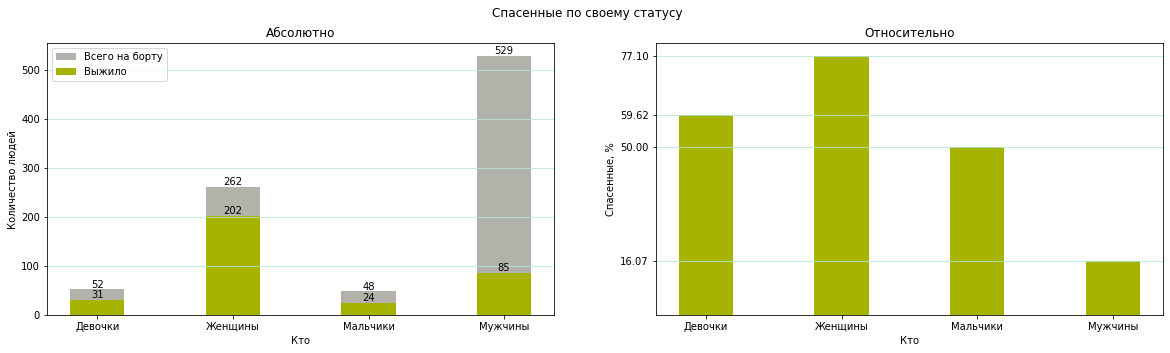

In [127]:
def translate_and_to_numpy(value_counts):
    who_eng_rus_pairs = (('man', 'Мужчины'),
                         ('woman', 'Женщины'),
                         ('girl', 'Девочки'),
                         ('boy', 'Мальчики'))
    return np.array(sorted(
        [(rus, value_counts[eng]) for eng, rus in who_eng_rus_pairs],
        key=lambda x: x[0]
    ))

who_items_all = translate_and_to_numpy(dict(df[who].value_counts()))
who_items_alive = translate_and_to_numpy(dict(df_alive[who].value_counts()))

# строим 
fig, (axes_absolutely, axes_relatively) = plt.subplots(*two_axes_in_row)
fig.set_size_inches(*two_axes_size)
fig.suptitle('Спасенные по своему статусу')

for item, label, color in (
    (who_items_all, 'Всего на борту', second_neutral_color), 
    (who_items_alive, 'Выжило', good_color)): 
    bar = axes_absolutely.bar(np.arange(4),  
                              item[:, 1].astype(int), 
                              width=bar_width, 
                              label=label, color=color)

    axes_absolutely.bar_label(bar, labels=item[:, 1])


axes_absolutely.set_title('Абсолютно')
axes_absolutely.set_xlabel('Кто')
axes_absolutely.set_ylabel('Количество людей')
axes_absolutely.legend()

alive_percentages = (who_items_alive[:, 1].astype(int) / 
                     who_items_all[:, 1].astype(int) * 100)
axes_relatively.bar(np.arange(4), alive_percentages, 
                    width=bar_width, color=good_color)

axes_relatively.set_title('Относительно')
axes_relatively.set_yticks(alive_percentages)
axes_relatively.set_xlabel('Кто')
axes_relatively.set_ylabel('Спасенные, %')

for axes in (axes_absolutely, axes_relatively): 
    axes.set_xticks(np.arange(4))
    axes.set_xticklabels(who_items_all[:, 0])
    axes.grid(True, axis='y', color=neutral_color)

plt.show()

### Изменение в соотношении классов
Первый и третий класс поменялись местами, учитывая, что в третьем классе было существенно больше людей, этот факт подтверждает тезис о том, что в первом классе безопасность была куда выше, чем в третьем. Второй класс так и остался на третьем месте в этом рейтинге, но отрыв от лидеров сокращен. 

На результаты большое влияние оказала существенная разница в количестве людей. 


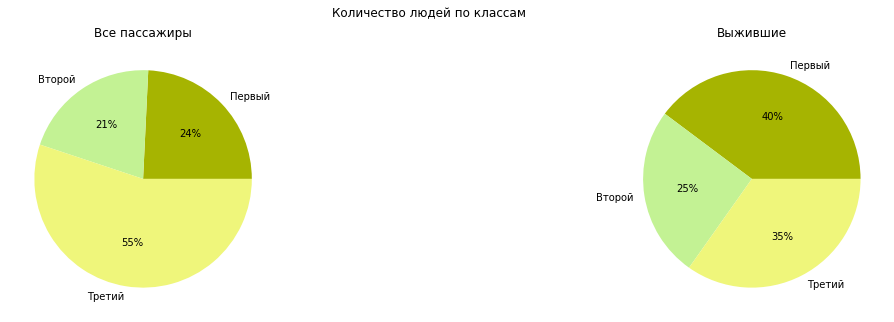

In [137]:
fig, (axes_all, axes_alive) = plt.subplots(*two_axes_in_row)
fig.set_size_inches(*two_axes_size)
fig.suptitle('Количество людей по классам')

classes_all = sorted(df[pclass].value_counts().items(), key=lambda x: x[0])
classes_alive = sorted(df_alive[pclass].value_counts().items(), key=lambda x: x[0])

label_texts = {1: 'Первый', 2: 'Второй', 3: 'Третий'}

# [[x, y], [x, y], [x, y]] -> [[x, x, x], [y, y, y]] -> [x, x, x], [y, y, y]
labels_all, x_all = zip(*classes_all)
labels_all = [label_texts[i] for i in labels_all]

labels_alive, x_alive = zip(*classes_alive)
labels_alive = [label_texts[i] for i in labels_alive]

axes_all.pie(x_all, labels=labels_all, autopct='%1.0f%%', 
             colors=(good_color, 
                     second_good_color, 
                     thrid_good_color))
axes_all.set_title('Все пассажиры')

axes_alive.pie(x_alive, labels=labels_alive, autopct='%1.0f%%', 
               colors=(good_color, 
                       second_good_color, 
                       thrid_good_color))
axes_alive.set_title('Выжившие')

plt.show()

### Изменение соотношений возрастов людей
На удивление мое предположение о том, что люди 20-30 вырвутся вперед по числу спасшихся, не подтвердилось, соотношение возрастов осталось примерно таким же, как и до крушения лайнера.

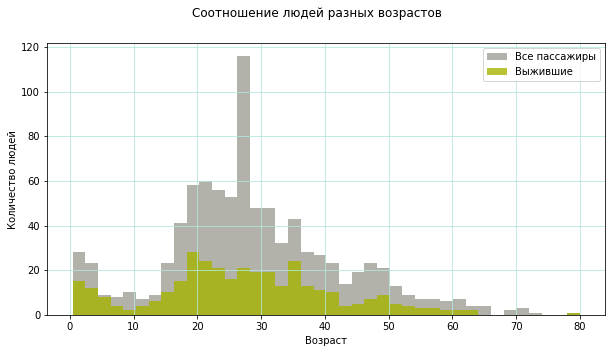

In [148]:
fig, axes = plt.subplots()
fig.set_size_inches(*one_axes_size)
fig.suptitle('Соотношение людей разных возрастов')

bins = 40

df[age].hist(bins=bins, ax=axes, label='Все пассажиры', color=second_neutral_color)
df_alive[age].hist(bins=bins, ax=axes, alpha=0.8, label='Выжившие', color=good_color)

axes.set_xlabel('Возраст')
axes.set_ylabel('Количество людей')

axes.grid(True, color=neutral_color)
axes.legend()
plt.show()

### Изменение в количестве одиночек
В живых осталось немного меньше одиноких людей, нежели людей, которые отправились в путешествие с семьей, при том, что изначально одиноких людей было на 35% больше.

Сила семьи, какой еще вывод сделать.

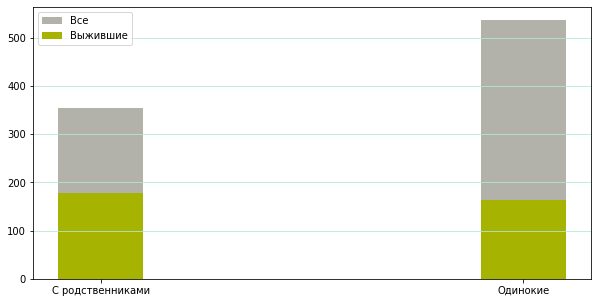

In [152]:
fig, axes = plt.subplots()
fig.set_size_inches(*one_axes_size)

alone_all = np.array(tuple(df[alone].value_counts().items()))
axes.bar(alone_all[:, 0], alone_all[:, 1], 
         width=slim_bar_width, label='Все', color=second_neutral_color)

alone_alive = np.array(tuple(df_alive[alone].value_counts().items()))
axes.bar(alone_alive[:, 0], alone_alive[:, 1], 
         width=slim_bar_width, label='Выжившие', color=good_color)

axes.set_xticks((0, 1))
axes.set_xticklabels(('С родственниками', 'Одинокие'), rotation='horizontal')
axes.legend()
axes.grid(True, axis='y', color=neutral_color)
plt.show()